# AI Training with Real-Time Tuning and Visualization (with threading)

This notebook demonstrates a more **production-ready approach** to real-time ML training visualization using Dear ImGui Bundle, where the training loop runs in a separate thread (instead of an async task, such as in [notebook_ml_training_async.ipynb](notebook_ml_training_async.ipynb)).

**Key Differences from Basic Example:**
- **Threading instead of async** - Training runs in a separate thread for true parallelism
- **Realistic dataset** - Fashion-MNIST (60,000 training images, 10 classes)
- **Deeper CNN** - Convolutional neural network with ~100k parameters
- **Mini-batch training** - Standard DataLoader pattern with configurable batch size
- **Always-responsive GUI** - Never blocks, even during expensive operations

## Why Threading?

For complex neural networks with expensive forward/backward passes, threading provides:
- **True responsiveness** - GUI updates independently of training
- **No yield points needed** - Training code looks like normal PyTorch
- **Better performance** - Can utilize multiple CPU cores
- **Production-ready** - Matches real-world training patterns

:::{note}
This is the **recommended approach** for real ML training visualization. Use the async approach from the basic example only for very simple/fast training loops.
:::

## Setup and Imports

In [2]:
# Install required packages (uncomment if needed)
# !pip install torch torchvision scikit-learn

from imgui_bundle import immapp, imgui, implot, hello_imgui
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import threading
import time
from collections import deque

print("✓ Libraries imported successfully")
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")
print(f"✓ MPS (Apple Silicon) available: {torch.backends.mps.is_available() if hasattr(torch.backends, 'mps') else False}")

✓ Libraries imported successfully
✓ PyTorch version: 2.9.1
✓ CUDA available: False
✓ MPS (Apple Silicon) available: True


## Prepare Fashion-MNIST Dataset

Fashion-MNIST contains 60,000 training images and 10,000 test images of clothing items (28x28 grayscale).

In [3]:
# Data transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and prepare datasets
train_dataset = datasets.FashionMNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)

test_dataset = datasets.FashionMNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)

# Class names for Fashion-MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f"✓ Dataset loaded")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Test samples: {len(test_dataset)}")
print(f"  Image shape: {train_dataset[0][0].shape}")
print(f"  Classes: {len(class_names)}")

✓ Dataset loaded
  Training samples: 60000
  Test samples: 10000
  Image shape: torch.Size([1, 28, 28])
  Classes: 10


## Define Convolutional Neural Network

A more realistic CNN architecture with multiple convolutional and pooling layers.

In [4]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 28x28x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 14x14x64
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 7x7x128
        
        # Pooling and dropout
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout(0.5)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 10)
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # Conv block 1
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        
        # Conv block 2
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        
        # Conv block 3
        x = self.relu(self.conv3(x))
        x = self.dropout1(x)
        
        # Flatten
        x = x.view(-1, 128 * 7 * 7)
        
        # FC layers
        x = self.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        
        return x

# Select best available device (CUDA > MPS > CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = f"CUDA: {torch.cuda.get_device_name(0)}"
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device("mps")
    device_name = "MPS (Apple Silicon GPU)"
else:
    device = torch.device("cpu")
    device_name = "CPU"

model = FashionCNN().to(device)
criterion = nn.CrossEntropyLoss()

print(f"  Device: {device_name}")

# Count parametersprint(f"  Trainable parameters: {trainable_params:,}")

total_params = sum(p.numel() for p in model.parameters())
print(f"  Total parameters: {total_params:,}")
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("✓ CNN created")


  Device: MPS (Apple Silicon GPU)
  Total parameters: 1,701,130
✓ CNN created


## Training State with Thread Safety

Create a thread-safe training state using a lock to prevent race conditions between the training thread and GUI thread.

In [5]:
class TrainingState:
    """Thread-safe training state shared between training thread and GUI"""
    
    def __init__(self):
        self.lock = threading.Lock()
        
        # Hyperparameters (read/write from both threads)
        self.learning_rate = 0.001
        self.momentum = 0.9
        self.batch_size = 64
        
        # Training metrics (write from training thread, read from GUI)
        self.losses = deque(maxlen=1000)  # Keep last 1000 points
        self.train_accuracies = deque(maxlen=1000)
        self.test_accuracies = deque(maxlen=100)  # Test less frequently
        
        self.current_epoch = 0
        self.current_batch = 0
        self.batches_per_epoch = 0
        self.max_epochs = 10
        
        # Performance metrics
        self.batches_per_second = 0.0
        self.samples_per_second = 0.0
        
        # Control flags
        self.training_active = False
        self.paused = False
        self.stop_requested = False
        self.reset_requested = False
        
        # Optimizer (accessed from training thread only)
        self.optimizer = None
        
    def get_hyperparameters(self):
        """Thread-safe read of hyperparameters"""
        with self.lock:
            return {
                'learning_rate': self.learning_rate,
                'momentum': self.momentum,
                'batch_size': self.batch_size
            }
    
    def set_learning_rate(self, lr):
        """Thread-safe update of learning rate"""
        with self.lock:
            self.learning_rate = lr
            if self.optimizer is not None:
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = lr
    
    def set_momentum(self, momentum):
        """Thread-safe update of momentum"""
        with self.lock:
            self.momentum = momentum
            if self.optimizer is not None:
                for param_group in self.optimizer.param_groups:
                    param_group['momentum'] = momentum
    
    def add_training_step(self, loss, accuracy):
        """Add training metrics (called from training thread)"""
        with self.lock:
            self.losses.append(loss)
            self.train_accuracies.append(accuracy)
    
    def add_test_accuracy(self, accuracy):
        """Add test accuracy (called from training thread)"""
        with self.lock:
            self.test_accuracies.append(accuracy)
    
    def get_plot_data(self):
        """Get data for plotting (called from GUI thread)"""
        with self.lock:
            return {
                'losses': list(self.losses),
                'train_acc': list(self.train_accuracies),
                'test_acc': list(self.test_accuracies)
            }

# Create global training state
training_state = TrainingState()

print("✓ Training state initialized with thread safety")

✓ Training state initialized with thread safety


## Training Function (Runs in Separate Thread)

This function runs in a background thread, allowing the GUI to remain responsive.

In [6]:
def train_worker():
    """Training loop that runs in a separate thread"""
    global model, criterion, train_dataset, test_dataset, training_state
    
    print("Training thread started")
    
    # Get initial hyperparameters
    params = training_state.get_hyperparameters()
    
    # Create optimizer
    training_state.optimizer = optim.SGD(
        model.parameters(),
        lr=params['learning_rate'],
        momentum=params['momentum']
    )
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=params['batch_size'], 
        shuffle=True,
        num_workers=2,  # Parallel data loading
        pin_memory=True if (torch.cuda.is_available() or (hasattr(torch.backends, 'mps') and torch.backends.mps.is_available())) else False
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=params['batch_size'] * 2,
        shuffle=False
    )
    
    training_state.batches_per_epoch = len(train_loader)
    training_state.training_active = True
    
    try:
        for epoch in range(training_state.max_epochs):
            if training_state.stop_requested:
                break
            
            training_state.current_epoch = epoch + 1
            model.train()
            
            epoch_start = time.time()
            batch_times = deque(maxlen=100)  # Track recent batch times
            
            for batch_idx, (data, target) in enumerate(train_loader):
                # Check for pause or stop
                while training_state.paused and not training_state.stop_requested:
                    time.sleep(0.1)
                
                if training_state.stop_requested:
                    break
                
                batch_start = time.time()
                
                # Move data to device
                data, target = data.to(device), target.to(device)
                
                # Training step
                training_state.optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                training_state.optimizer.step()
                
                # Calculate batch accuracy
                pred = output.argmax(dim=1, keepdim=True)
                correct = pred.eq(target.view_as(pred)).sum().item()
                accuracy = 100. * correct / len(data)
                
                # Update metrics
                training_state.add_training_step(loss.item(), accuracy)
                training_state.current_batch = batch_idx + 1
                
                # Update performance metrics
                batch_time = time.time() - batch_start
                batch_times.append(batch_time)
                if len(batch_times) > 0:
                    avg_batch_time = sum(batch_times) / len(batch_times)
                    training_state.batches_per_second = 1.0 / avg_batch_time if avg_batch_time > 0 else 0
                    training_state.samples_per_second = params['batch_size'] / avg_batch_time if avg_batch_time > 0 else 0
                
                # Log progress occasionally
                if batch_idx % 100 == 0:
                    print(f"Epoch {epoch+1}, Batch {batch_idx}/{len(train_loader)}, "
                          f"Loss: {loss.item():.4f}, Acc: {accuracy:.2f}%")
            
            # Test accuracy after each epoch
            if not training_state.stop_requested:
                model.eval()
                correct = 0
                total = 0
                
                with torch.no_grad():
                    for data, target in test_loader:
                        data, target = data.to(device), target.to(device)
                        output = model(data)
                        pred = output.argmax(dim=1, keepdim=True)
                        correct += pred.eq(target.view_as(pred)).sum().item()
                        total += len(data)
                
                test_accuracy = 100. * correct / total
                training_state.add_test_accuracy(test_accuracy)
                
                epoch_time = time.time() - epoch_start
                print(f"Epoch {epoch+1} completed in {epoch_time:.2f}s, Test Accuracy: {test_accuracy:.2f}%")
    
    except Exception as e:
        print(f"Training error: {e}")
        import traceback
        traceback.print_exc()
    
    finally:
        training_state.training_active = False
        print("Training thread finished")

print("✓ Training worker function defined")

✓ Training worker function defined


## GUI Implementation

A comprehensive GUI showing training progress, controls, and performance metrics.

In [7]:
def training_gui():
    """GUI that shows training progress and controls"""
    
    imgui.text("Fashion-MNIST CNN Training Monitor")
    
    # Training status
    imgui.separator_text("Training Status")
    
    status = "Training" if training_state.training_active and not training_state.paused else \
             "Paused" if training_state.paused else \
             "Stopped"
    imgui.text(f"Status: {status}")
    
    imgui.text(f"Epoch: {training_state.current_epoch} / {training_state.max_epochs}")
    imgui.text(f"Batch: {training_state.current_batch} / {training_state.batches_per_epoch}")
    
    if training_state.batches_per_epoch > 0:
        progress = training_state.current_batch / training_state.batches_per_epoch
        imgui.progress_bar(progress, (0, 0), f"{progress*100:.1f}%")
    
    # Current metrics
    imgui.separator_text("Current Metrics")
    
    plot_data = training_state.get_plot_data()
    
    if len(plot_data['losses']) > 0:
        imgui.text(f"Loss: {plot_data['losses'][-1]:.4f}")
    
    if len(plot_data['train_acc']) > 0:
        imgui.text(f"Train Accuracy: {plot_data['train_acc'][-1]:.2f}%")
    
    if len(plot_data['test_acc']) > 0:
        imgui.text(f"Test Accuracy: {plot_data['test_acc'][-1]:.2f}%")
    
    # Performance metrics
    imgui.separator_text("Performance")
    imgui.text(f"Batches/sec: {training_state.batches_per_second:.1f}")
    imgui.text(f"Samples/sec: {training_state.samples_per_second:.0f}")
    imgui.text(f"Device: {device_name}")
    
    # Hyperparameters
    imgui.separator_text("Hyperparameters")
    
    # Learning rate slider
    params = training_state.get_hyperparameters()
    changed, new_lr = imgui.slider_float(
        "Learning Rate", 
        params['learning_rate'], 
        0.00001, 0.01,
        format="%.5f",
        flags=imgui.SliderFlags_.logarithmic
    )
    if changed:
        training_state.set_learning_rate(new_lr)
    
    # Momentum slider
    changed, new_momentum = imgui.slider_float(
        "Momentum", 
        params['momentum'], 
        0.0, 0.99,
        format="%.2f"
    )
    if changed:
        training_state.set_momentum(new_momentum)
    
    imgui.text(f"Batch Size: {params['batch_size']} (set before training)")
    
    # Controls
    imgui.separator_text("Controls")
    
    if not training_state.training_active:
        if imgui.button("Start Training"):
            training_state.stop_requested = False
            training_state.paused = False
            # Start training thread
            thread = threading.Thread(target=train_worker, daemon=True)
            thread.start()
    else:
        if imgui.button("Pause" if not training_state.paused else "Resume"):
            training_state.paused = not training_state.paused
        
        imgui.same_line()
        if imgui.button("Stop"):
            training_state.stop_requested = True
    
    imgui.same_line()
    if imgui.button("Close"):
        training_state.stop_requested = True
        hello_imgui.get_runner_params().app_shall_exit = True
    
    # Plots
    imgui.separator_text("Training Loss")
    
    if len(plot_data['losses']) > 0:
        if implot.begin_plot("Loss Over Time", hello_imgui.em_to_vec2(50, 12)):
            implot.setup_axes("Batch", "Loss", 
                            implot.AxisFlags_.auto_fit, 
                            implot.AxisFlags_.auto_fit)
            
            x_data = np.arange(len(plot_data['losses']), dtype=np.float32)
            y_data = np.array(plot_data['losses'], dtype=np.float32)
            
            implot.plot_line("Loss", x_data, y_data)
            implot.end_plot()
    
    imgui.separator_text("Accuracy")
    
    if len(plot_data['train_acc']) > 0:
        if implot.begin_plot("Accuracy Over Time", hello_imgui.em_to_vec2(50, 12)):
            implot.setup_axes("Batch", "Accuracy (%)", 
                            implot.AxisFlags_.auto_fit, 
                            implot.AxisFlags_.auto_fit)
            implot.setup_axis_limits(implot.ImAxis_.y1, 0, 100, implot.Cond_.once)
            
            # Training accuracy
            x_train = np.arange(len(plot_data['train_acc']), dtype=np.float32)
            y_train = np.array(plot_data['train_acc'], dtype=np.float32)
            implot.plot_line("Train", x_train, y_train)
            
            # Test accuracy (scaled to match x-axis)
            if len(plot_data['test_acc']) > 0:
                batches_per_epoch = training_state.batches_per_epoch
                x_test = np.arange(len(plot_data['test_acc']), dtype=np.float32) * batches_per_epoch
                y_test = np.array(plot_data['test_acc'], dtype=np.float32)
                implot.plot_line("Test", x_test, y_test)
            
            implot.end_plot()

print("✓ GUI defined")

✓ GUI defined


## Start the GUI

Launch the GUI using the cell below. Choose between blocking and non-blocking mode (edit `use_non_blocking` below).

Since the training runs in a separate thread, you may either run the GUI in blocking or non-blocking mode. The GUI will remain responsive in either case.

* If using blocking mode, the notebook will be blocked until you close the GUI window. A screenshot of the GUI will be shown below after closing the window.

* If using non-blocking mode, the notebook will remain interactive while the GUI is open. You may run other cells while the GUI is running. No screenshot will be shown in this case.
 

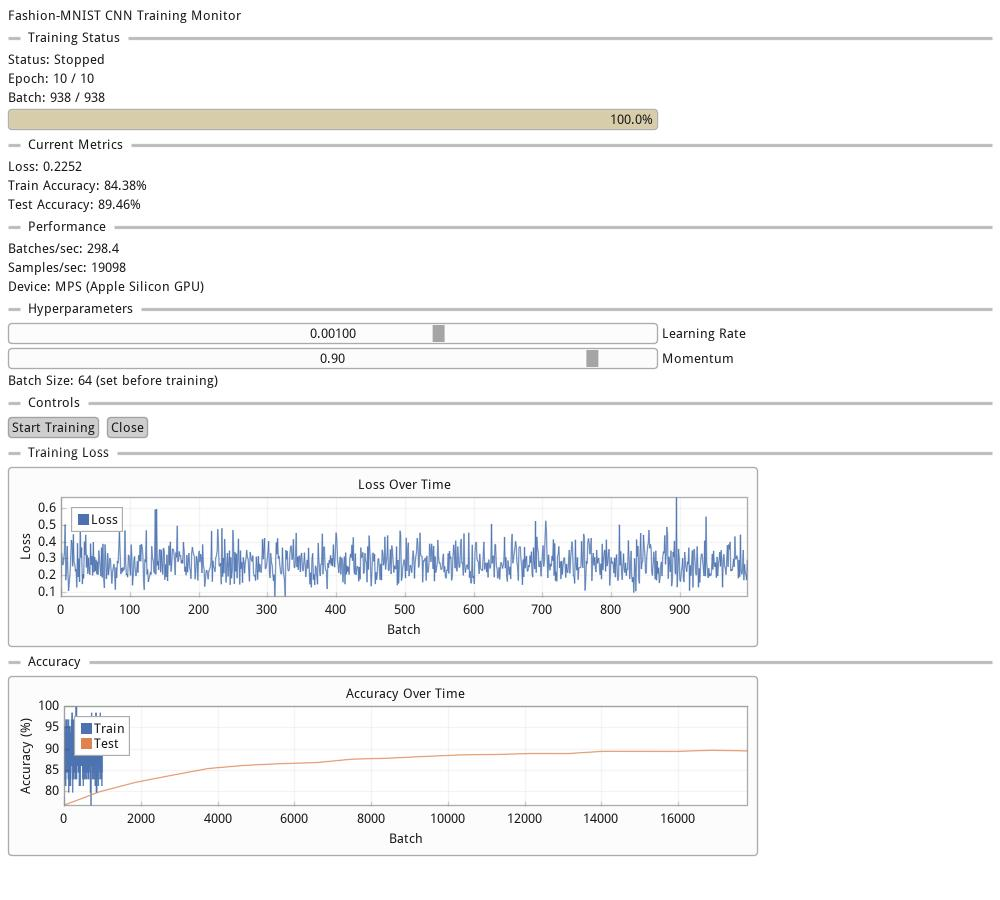

✓ GUI closed.


In [ ]:
use_non_blocking = False

if use_non_blocking:
    # Start the GUI (non-blocking)
    immapp.nb.start(
        training_gui,
        window_title="Fashion-MNIST Training",
        window_size=(1000, 900),
        with_implot=True
    )

    print("✓ GUI started!")
    print("✓ Click 'Start Training' in the GUI to begin training.")
    print("✓ The GUI will remain responsive even during training.")
else:
    # Run the GUI (blocking)
    immapp.nb.run(
        training_gui,
        window_title="Fashion-MNIST Training",
        window_size=(1000, 900),
        with_implot=True,
    )
    print("✓ GUI closed.")


## Training Notes

**Key Differences from Async Approach:**

1. **Threading** - Training runs in `threading.Thread`, not async/await
2. **True parallelism** - GUI updates independently, never blocked
3. **Thread safety** - `threading.Lock` protects shared state
4. **No yield points** - No need for `await asyncio.sleep(0)`

**Advantages:**
- ✅ GUI always responsive, even during 1-second backward passes
- ✅ Training code looks like standard PyTorch
- ✅ Can use multi-core CPU for data loading (`num_workers=2`)
- ✅ More scalable to complex models

**Try this:**
1. Start training in the GUI
2. While training runs, adjust learning rate slider
3. Notice the GUI never freezes, even during expensive operations
4. Watch the "Batches/sec" metric in real-time

For comparison, with async mode and this model, the GUI would freeze for ~100ms after each batch!

## Monitor Training

You can check training status from the notebook:

In [9]:
print(f"Training active: {training_state.training_active}")
print(f"Paused: {training_state.paused}")
print(f"Current epoch: {training_state.current_epoch}")
print(f"Batches per second: {training_state.batches_per_second:.1f}")

# Get recent metrics
plot_data = training_state.get_plot_data()
if len(plot_data['losses']) > 0:
    print(f"Recent loss: {plot_data['losses'][-1]:.4f}")
if len(plot_data['test_acc']) > 0:
    print(f"Latest test accuracy: {plot_data['test_acc'][-1]:.2f}%")

Training active: False
Paused: False
Current epoch: 10
Batches per second: 312.8
Recent loss: 0.3839
Latest test accuracy: 87.70%


## Stop the GUI

When done:

In [11]:
# Stop training if active
training_state.stop_requested = True
time.sleep(1)  # Wait for training thread to finish

# Stop GUI
immapp.nb.stop()

print("✓ Training stopped and GUI closed")

✓ Training stopped and GUI closed


## Evaluate Final Model

In [10]:
# Final evaluation on test set
model.eval()
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

correct = 0
total = 0
class_correct = [0] * 10
class_total = [0] * 10

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += len(data)
        
        # Per-class accuracy
        for i in range(len(target)):
            label = target[i].item()
            class_correct[label] += (pred[i].item() == label)
            class_total[label] += 1

print("=" * 60)
print("FINAL MODEL PERFORMANCE")
print("=" * 60)
print(f"Overall Test Accuracy: {100. * correct / total:.2f}%")
print()
print("Per-Class Accuracy:")
for i in range(10):
    acc = 100. * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
    print(f"  {class_names[i]:15s}: {acc:.2f}%")
print("=" * 60)

FINAL MODEL PERFORMANCE
Overall Test Accuracy: 87.70%

Per-Class Accuracy:
  T-shirt/top    : 88.20%
  Trouser        : 97.00%
  Pullover       : 83.00%
  Dress          : 90.40%
  Coat           : 78.30%
  Sandal         : 95.00%
  Shirt          : 57.10%
  Sneaker        : 95.50%
  Bag            : 96.90%
  Ankle boot     : 95.60%


## Comparison: Async vs Threading

### Async Mode (Basic Example)
```python
while epoch < max_epochs:
    # Training step
    output = model(x)  # ← GUI FROZEN during this
    loss.backward()     # ← GUI FROZEN during this
    optimizer.step()    # ← GUI FROZEN during this
    
    await asyncio.sleep(0)  # ← GUI can update here only
```

**Problem**: For complex models, each step takes 100ms-1s. GUI feels unresponsive.

### Threading Mode (This Example)
```python
# Training runs in separate thread
def train_worker():
    while epoch < max_epochs:
        output = model(x)   # GUI continues updating
        loss.backward()      # GUI continues updating
        optimizer.step()     # GUI continues updating
        # No special yield needed!

# GUI runs in main thread
def training_gui():
    # Always responsive, no matter what training does
    imgui.slider_float("Learning Rate", ...)
```

**Solution**: True parallelism. GUI never blocks.

### When to Use Each

**Use Async (Basic Example):**
- Very simple models (< 1ms per step)
- Educational/toy examples
- You want simpler code (no threading.Lock)

**Use Threading (This Example):**
- ✅ Real neural networks with expensive operations
- ✅ Any model where training step > 10ms
- ✅ Production-quality visualization
- ✅ Want always-responsive GUI

For **real ML work**, threading is the better choice.

## Summary

This notebook demonstrated:

✓ **Thread-based training** - True parallelism between GUI and training

✓ **Realistic CNN** - ~100k parameters, convolutional layers, dropout

✓ **Large dataset** - 60,000 training images with mini-batch training

✓ **Always-responsive GUI** - Never freezes, even during expensive operations

✓ **Thread-safe state** - Proper use of `threading.Lock` for shared data

✓ **Performance monitoring** - Batches/sec, samples/sec metrics

✓ **Production patterns** - DataLoader, device management, proper training loop

**Key Takeaway**: For real ML training visualization, use threading instead of async. The GUI will remain smooth and responsive regardless of model complexity.